# Cost of Wind Energy Review: 2025 Edition
This notebook runs the WAVES model and saves results to intermediate .csv files which can be used for plotting in the Annual Reporting Workflow.
https://github.com/dmulash/Annual_Reporting_Workflow/tree/main

In [1]:
from time import perf_counter
from pathlib import Path

import pandas as pd

from waves import Project
from waves.utilities import load_yaml

# Update core Pandas display settings
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Configuration
For instructions on a fresh WAVES installation, see:
https://nrel.sharepoint.com/:w:/r/sites/CostofWindEnergyReview/Shared%20Documents/Cost%20of%20Wind%20Energy%20Review%20-%202025%20Edition/cower2025-Workflow%20Documentation.docx?d=w4ea0a35c7f5c4b4fb2d27ff21188c447&csf=1&web=1&e=wtr1Xd

In [2]:
library_path = Path("../library/base_2024/")
config_fixed = load_yaml(library_path / "project/config", "base_fixed_bottom_2022.yaml")
config_floating = load_yaml(library_path / "project/config", "base_floating_2022.yaml")

Now, we'll create a Project for each of the fixed bottom and floating offshore scenarios, showing
the time it takes to initialize each project. Note that we're initializing using the
`Project.from_dict()` `classmethod` because the configurations are designed to also work with the
WAVES command line interface (CLI).

In [3]:
# Add in the library path for both configurations
config_fixed.update({"library_path": library_path,})
config_floating.update({"library_path": library_path,})

start1 = perf_counter()
project_fixed = Project.from_dict(config_fixed)
end1 = perf_counter()

start2 = perf_counter()
project_floating = Project.from_dict(config_floating)
end2 = perf_counter()

print(f"Fixed bottom loading time: {(end1-start1):,.2f} seconds")
print(f"Floating loading time: {(end2-start2):,.2f} seconds")

'H' is deprecated and will be removed in a future version, please use 'h' instead.

ORBIT library intialized at 'C:\Users\pduffy\Documents\repos\WAVES\WAVES\library\base_2024'


Missing data in columns ['bury_speed']; all values will be calculated.FutureWarning: C:\Users\pduffy\Documents\repos\WAVES\WAVES\waves\project.py:116
'H' is deprecated and will be removed in a future version, please use 'h' instead.

Fixed bottom loading time: 3.96 seconds
Floating loading time: 2.91 seconds


Missing data in columns ['bury_speed']; all values will be calculated.

### Visualize the wind farm

Both projects use the same layout, so we'll plot just the fixed bottom plant, noting that the self-connected line at the "OSS1" indicates the unmodeled interconnection point via a modeled export cable.

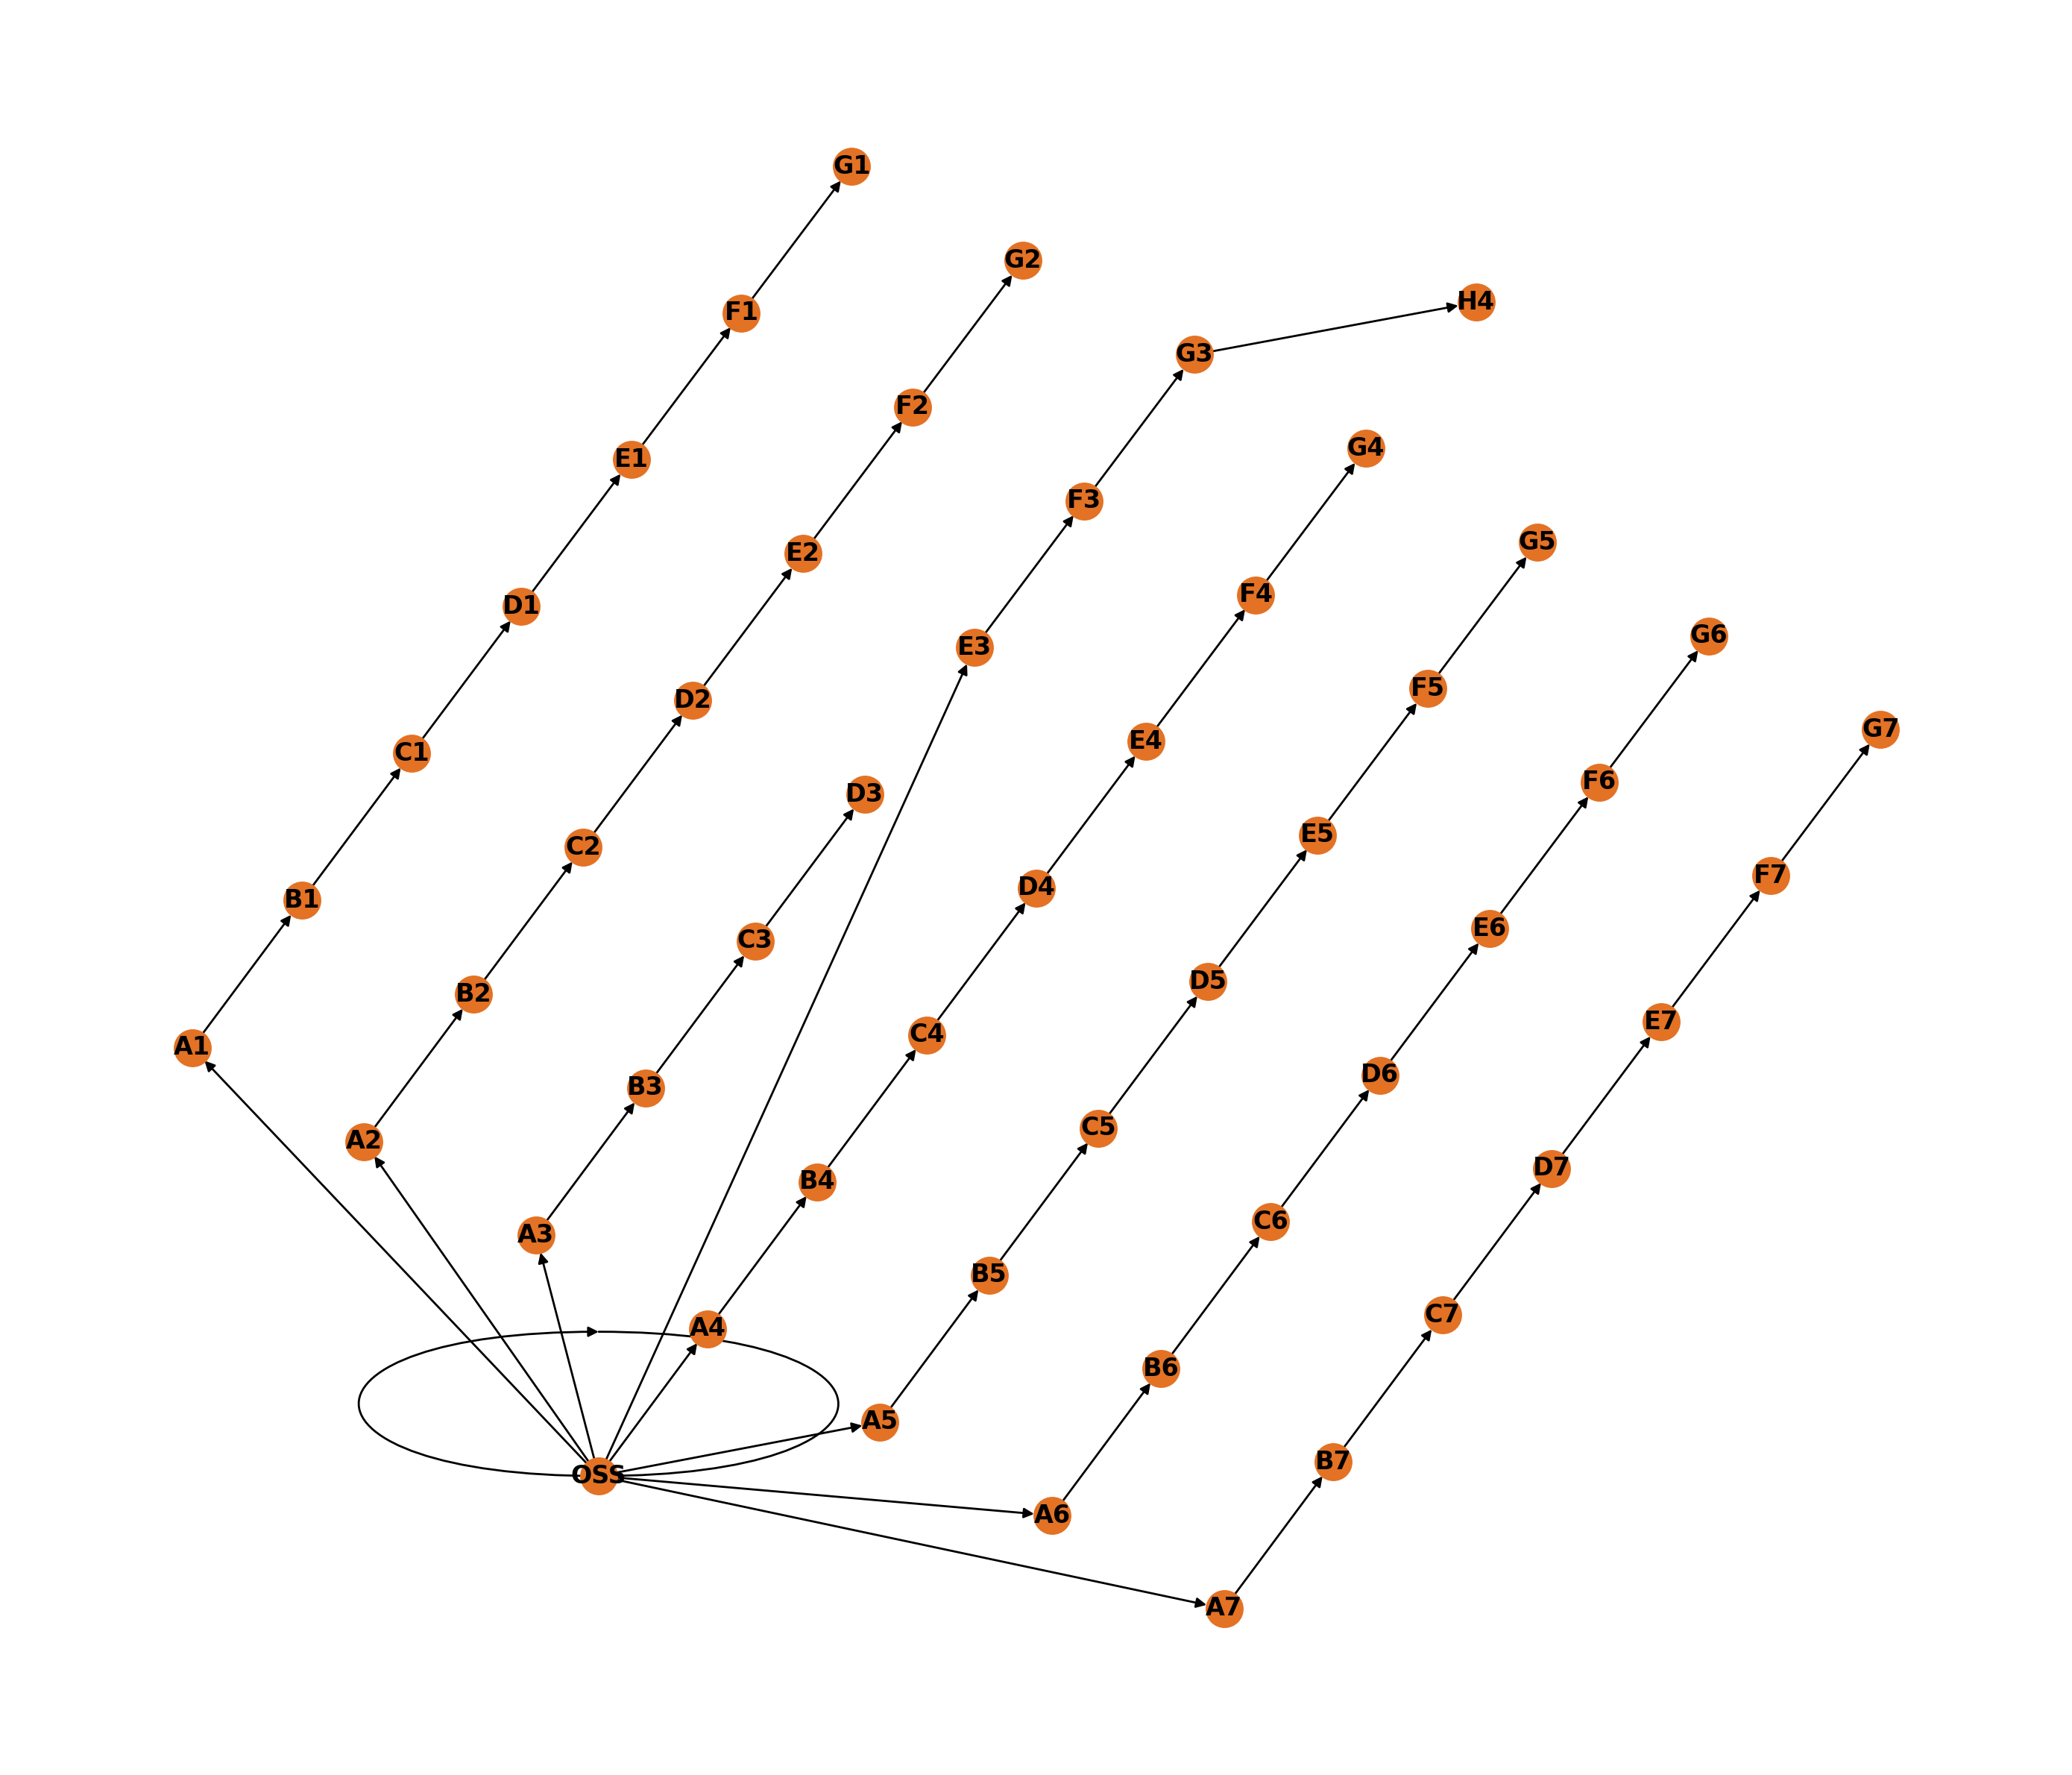

In [4]:
#TODO: update the layouts with appropriate numbers of turbines per string rated capacity
project_fixed.plot_farm()

## Run the Projects

Now we'll, run all both the fixed-bottom and floating offshore wind scenarios. Notice that there are
additional parameters to use for running the FLORIS model in WAVES: `"wind_rose"` and
`"time_series"`. While time series is more accurate, it can take multiple hours to run for a
20-year, hourly timeseries, and lead to similar results, so we choose the model that will take only
a few minutes to run, instead.

Additionally, the wind rose can be computed based on the full weather profile,
`full_wind_rose=True`, for little added computation since WAVES computes a wind rose for each month
of the year, for a more accurate energy output. However, we're using just the weather profile used
in the O&M phase: `full_wind_rose=False`.

In [5]:
start1 = perf_counter()
project_fixed.run(
    full_wind_rose=False,  # use the WOMBAT (operational) date range
)
project_fixed.wombat.env.cleanup_log_files()  # Delete logging data from the WOMBAT simulations
end1 = perf_counter()

start2 = perf_counter()
project_floating.run(full_wind_rose=False)
project_floating.wombat.env.cleanup_log_files()  # Delete logging data from the WOMBAT simulations
end2 = perf_counter()

print("-" * 29)  # separate our timing from the ORBIT and FLORIS run-time warnings
print(f"Fixed run time: {end1 - start1:,.2f} seconds")
print(f"Floating run time: {end2 - start2:,.2f} seconds")

Missing data in columns ['bury_speed']; all values will be calculated.SettingWithCopyWarning: C:\Users\pduffy\Documents\repos\WAVES\WAVES\waves\project.py:759

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: c:\Users\pduffy\AppData\Local\anaconda3\envs\waves-env\lib\site-packages\floris\core\wake_deflection\gauss.py:328
invalid value encountered in divideRuntimeWarning: c:\Users\pduffy\AppData\Local\anaconda3\envs\waves-env\lib\site-packages\floris\core\wake_deflection\gauss.py:498
invalid value encountered in divideUserWarning: C:\Users\pduffy\Documents\repos\WAVES\ORBIT\ORBIT\phases\design\array_system_design.py:1087
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: C:\Users\pduffy\Documents\repos\WAVES\ORBIT\ORBIT\pha

-----------------------------
Fixed run time: 118.15 seconds
Floating run time: 219.12 seconds


In 2025, we added an ORBIT method to capture the types supply chain investments the first U.S. projects made in things like vessels, ports, manufacturing infrastructure, and community benefit agreements.

In [6]:
project_fixed.orbit.supply_chain_capex
project_floating.orbit.supply_chain_capex #TODO: consider incerasing the floating supply chain CapEx

453600000

## Gather the results

Another of the conveniences with using WAVES to run all three models is that some of the core
metrics are wrapped in the `Project` API, with the ability to generate a report of a selection of
the metrics.

Below, we define the inputs for the report by the following paradigm, where the `"metric"` and
`"kwargs"` keys must not be changed to ensure their values are read correctly. See the following
setup for details.

```python
configuration_dictionary = {
    "Descriptive Name of Metric": {
        "metric": "metric_method_name",
        "kwargs": {
            "metric_kwarg_1": "kwarg_1_value", ...
        }
    }
}
```

Below, it can be seen that many metrics do not have the `"kwargs"` dictionary item. This is because
an empty dictionary can be assumed to be used when no values need to be configured. In other words,
the default method configurations will be relied on, if not otherwise specified.

In [7]:
metrics_configuration = {
    "# Turbines": {"metric": "n_turbines"},
    "Turbine Rating (MW)": {"metric": "turbine_rating"},
    "Project Capacity (MW)": {
        "metric": "capacity",
        "kwargs": {"units": "mw"}
    },
    "# OSS": {"metric": "n_substations"},
    "Total Export Cable Length (km)": {"metric": "export_system_total_cable_length"},
    "Total Array Cable Length (km)": {"metric": "array_system_total_cable_length"},
    "CapEx ($)": {"metric": "capex"},
    "CapEx per kW ($/kW)": {
        "metric": "capex",
        "kwargs": {"per_capacity": "kw"}
    },
    "OpEx ($)": {"metric": "opex"},
    "OpEx per kW ($/kW)": {"metric": "opex", "kwargs": {"per_capacity": "kw"}},
    "AEP (MWh)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "aep": True}
    },
    "AEP per kW (MWh/kW)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "per_capacity": "kw", "aep": True}
    },
    "Net Capacity Factor With All Losses (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net"}
    },
    "Gross Capacity Factor (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "gross"}
    },
    "Energy Availability (%)": {
        "metric": "availability",
        "kwargs": {"which": "energy"}
    },
    "LCOE ($/MWh)": {"metric": "lcoe"},
}


# Define the final order of the metrics in the resulting dataframes
metrics_order = [
    "# Turbines",
    "Turbine Rating (MW)",
    "Project Capacity (MW)",
    "# OSS",
    "Total Export Cable Length (km)",
    "Total Array Cable Length (km)",
    "FCR (%)",
    "Offtake Price ($/MWh)",
    "CapEx ($)",
    "CapEx per kW ($/kW)",
    "OpEx ($)",
    "OpEx per kW ($/kW)",
    "Annual OpEx per kW ($/kW)",
    "Energy Availability (%)",
    "Gross Capacity Factor (%)",
    "Net Capacity Factor With All Losses (%)",
    "AEP (MWh)",
    "AEP per kW (MWh/kW)",
    "LCOE ($/MWh)",
]

capex_order = [
    "Array System",
    "Export System",
    "Offshore Substation",
    "Substructure",
    "Scour Protection",
    "Mooring System",
    "Turbine",
    "Array System Installation",
    "Export System Installation",
    "Offshore Substation Installation",
    "Substructure Installation",
    "Scour Protection Installation",
    "Mooring System Installation",
    "Turbine Installation",
    "Soft",
    "Project",
    "Supply Chain", # note this addition from 2025
]
#TODO: revise ORBIT's cost breakdown methods to provide higher resolution on the line items and how we aggregate them, with clear descriptions for each.

Before we generate the report, let's see a CapEx breakdown of each scenario. To do this, we'll
access ORBIT's `ProjectManager` object directly to access model-specific functionality. This is
available for each model via:

- `project.orbit`: provides access to ORBIT's `ProjectManager`
- `project.wombat` provides access to WOMBAT's `Simulation`
- `project.floris` provides access to FLORIS's `FlorisModel`

In [8]:
# Capture the CapEx breakdown from each scenario
df_capex_fixed = pd.DataFrame(
    project_fixed.orbit.capex_breakdown.items(),
    columns=["Component", "CapEx ($) - Fixed"]
)
df_capex_floating = pd.DataFrame(
    project_floating.orbit.capex_breakdown.items(),
    columns=["Component", "CapEx ($) - Floating"]
)

# Compute the normalized CapEx for each scenario
df_capex_fixed["CapEx ($/kW) - Fixed"] = df_capex_fixed["CapEx ($) - Fixed"] / project_fixed.capacity("kw")
df_capex_floating["CapEx ($/kW) - Floating"] = df_capex_floating["CapEx ($) - Floating"] / project_floating.capacity("kw")

# Combine the results into one, easy to view dataframe
df_capex = df_capex_fixed.merge(
    df_capex_floating,
    on="Component",
    how="outer",
).fillna(0.0).set_index("Component")
df_capex = df_capex.iloc[pd.Categorical(df_capex.index, capex_order).argsort()]
df_capex

,CapEx ($) - Fixed,CapEx ($/kW) - Fixed,CapEx ($) - Floating,CapEx ($/kW) - Floating
Component,,,,
Array System,"134,289,182.70",223.82,"160,908,208.26",268.18
Export System,"265,812,746.00",443.02,"200,753,249.27",334.59
Offshore Substation,"233,500,922.72",389.17,"232,006,386.31",386.68
Substructure,"314,185,445.38",523.64,"800,743,873.88","1,334.57"
Scour Protection,"5,346,000.00",8.91,0.00,0.00
Mooring System,0.00,0.00,"339,550,977.65",565.92
Turbine,"1,020,000,000.00","1,700.00","1,020,000,000.00","1,700.00"
Array System Installation,"129,676,532.80",216.13,"269,591,779.74",449.32
Export System Installation,"43,654,139.65",72.76,"105,290,633.32",175.48


Now, let's generate the report, and then add in some additional reporting variables.

In [9]:
project_name_fixed = "COE 2025 - Fixed"
project_name_floating = "COE 2025 - Floating"

# Generate the reports using WAVES and the above configurations
# NOTE: the results are transposed to view them more easily for the example, otherwise
# each row would be a project, which is helpful for combining the results of many scenarios
report_df_fixed = project_fixed.generate_report(metrics_configuration, project_name_fixed).T
report_df_floating = project_floating.generate_report(metrics_configuration, project_name_floating).T

# Gather some additional metadata and results from the projects
n_years_fixed = project_fixed.operations_years
n_years_floating = project_floating.operations_years
additional_reporting_fixed = pd.DataFrame(
    [
        ["FCR (%)", project_fixed.fixed_charge_rate],
        ["Offtake Price ($/MWh)", project_fixed.offtake_price],
        [
            "Annual OpEx per kW ($/kW)",
            report_df_fixed.loc["OpEx per kW ($/kW)", project_name_fixed] / n_years_fixed
        ],
    ],
    columns=["Project"] + report_df_fixed.columns.tolist(),
).set_index("Project")

additional_reporting_floating = pd.DataFrame(
    [
        ["FCR (%)", project_floating.fixed_charge_rate],
        ["Offtake Price ($/MWh)", project_floating.offtake_price],
        [
            "Annual OpEx per kW ($/kW)",
            report_df_floating.loc["OpEx per kW ($/kW)", project_name_floating] / n_years_floating
        ],
    ],
    columns=["Project"] + report_df_floating.columns.tolist(),
).set_index("Project")

# Combine the additional metrics to the generated report
report_df_fixed = pd.concat((report_df_fixed, additional_reporting_fixed), axis=0).loc[metrics_order]
report_df_floating = pd.concat((report_df_floating, additional_reporting_floating), axis=0).loc[metrics_order]

# Combine both reports into one, easy to view dataframe
report_df = report_df_fixed.join(
    report_df_floating,
    how="outer",
).fillna(0.0)
report_df.index.name = "Metrics"

# Format percent-based rows to show as such, not as decimals
report_df.loc[report_df.index.str.contains("%")] *= 100

report_df

,COE 2025 - Fixed,COE 2025 - Floating
Metrics,,
# OSS,1.00,1.00
# Turbines,50.00,50.00
AEP (MWh),"2,297,691.76","2,507,996.45"
AEP per kW (MWh/kW),3.83,4.18
Annual OpEx per kW ($/kW),68.18,69.87
CapEx ($),"3,464,604,846.97","4,823,070,293.75"
CapEx per kW ($/kW),"5,774.34","8,038.45"
Energy Availability (%),95.28,91.60
FCR (%),6.48,6.48


In [10]:
print("Loss Breakdown Fixed-Bottom")
project_fixed.loss_ratio(breakdown=True)

Loss Breakdown Fixed-Bottom


,Loss Ratio (%)
Environmental Losses,1.59
Availability Losses,4.72
Wake Losses,7.82
Technical Losses,1.00
Electrical Losses,3.52
Total Losses,17.45


In [11]:
print("Loss Breakdown Floating")
project_floating.loss_ratio(breakdown=True)

Loss Breakdown Floating


,Loss Ratio (%)
Environmental Losses,1.59
Availability Losses,8.40
Wake Losses,6.33
Technical Losses,1.20
Electrical Losses,3.71
Total Losses,19.66


In [12]:
details_df = (
    project_fixed.generate_report_project_details()
    .set_index(["Assumption", "Units"])
    .rename(columns={"Value": "COE 2025 - Fixed"})
).join(
    project_floating.generate_report_project_details()
    .set_index(["Assumption", "Units"])
    .rename(columns={"Value": "COE 2025 - Floating"})
)
details_df

,,COE 2025 - Fixed,COE 2025 - Floating
Assumption,Units,,
Wind plant capacity,MW,600,600
Number of turbines,Number,50,50
Turbine rating,MW,12,12
Rotor diameter,m,215,215
Hub height,m,132,132
Specific power,W/m2,330.53,330.53
Water depth,m,34,739
Substructure type,-,Monopile,Semi-Submersible
Distance to port,km,116,189


# Data for Annual Reporting Workflow
Now we paste data to intermediate .csv files with data for each plot in the COWER slide deck.

### CapEx 

In [13]:
# Capture the CapEx breakdown from each scenario
df_capex_fixed = pd.DataFrame(
    project_fixed.orbit.capex_detailed_soft_capex_breakdown_per_kw.items(),
    columns=["Component", "$/kW"]
)
df_capex_floating = pd.DataFrame(
    project_floating.orbit.capex_detailed_soft_capex_breakdown_per_kw.items(),
    columns=["Component", "$/kW"]
)

In [14]:

# Drop unused rows
df_capex_fixed = df_capex_fixed.drop([5,6,7,8,9,10,12])
df_capex_floating = df_capex_floating.drop([5,6,7,8,9,11])

# Add install total, lease price, and project costs
default_lease_price = 122698898 / 600000 # $/kW
fixed_data = {"Component": ["Installation", "Lease Price", "Project Development"], "$/kW": [project_fixed.orbit.installation_capex_per_kw, default_lease_price, project_fixed.orbit.project_capex_per_kw - default_lease_price]}
floating_data = {"Component": ["Installation", "Lease Price", "Project Development"], "$/kW": [project_floating.orbit.installation_capex_per_kw, default_lease_price, project_floating.orbit.project_capex_per_kw - default_lease_price]}
df_to_add_fixed = pd.DataFrame(fixed_data)
df_to_add_floating = pd.DataFrame(floating_data)

# Append to results df
df_capex_fixed = pd.concat([df_capex_fixed, df_to_add_fixed], ignore_index=True)
df_capex_floating = pd.concat([df_capex_floating, df_to_add_floating], ignore_index=True)

In [15]:
# Sort like the image
ordered_components_fixed = [
    'Construction Insurance', 'Decommissioning', 'Construction Financing',
    'Procurement Contingency', 'Commissioning', 'Installation Contingency',
    'Array System', 'Export System', 'Offshore Substation', 'Scour Protection',
    'Substructure', 'Project Development', 'Installation',  'Lease Price',
    'Turbine', 'Supply Chain'
]
df_capex_fixed['Component'] = pd.Categorical(df_capex_fixed['Component'], categories=ordered_components_fixed, ordered=True)
df_capex_fixed = df_capex_fixed.sort_values('Component')

ordered_components_floating = [
    'Construction Insurance', 'Decommissioning', 'Construction Financing',
    'Procurement Contingency', 'Installation Contingency', 'Commissioning',
    'Array System', 'Export System', 'Offshore Substation', 'Substructure',
    'Mooring System', 'Installation', 'Project Development',  'Lease Price',
    'Turbine', 'Supply Chain'
]
df_capex_floating['Component'] = pd.Categorical(df_capex_floating['Component'], categories=ordered_components_floating, ordered=True)
df_capex_floating = df_capex_floating.sort_values('Component')

In [16]:
df_capex_fixed

,Component,$/kW
7,Construction Insurance,47.16
8,Decommissioning,88.00
12,Construction Financing,354.95
10,Procurement Contingency,206.88
9,Commissioning,47.16
11,Installation Contingency,173.48
0,Array System,223.82
1,Export System,443.02
2,Offshore Substation,389.17
3,Scour Protection,8.91


In [17]:
df_capex_floating

,Component,$/kW
7,Construction Insurance,67.42
8,Decommissioning,168.63
12,Construction Financing,502.00
10,Procurement Contingency,281.71
11,Installation Contingency,332.44
9,Commissioning,67.42
0,Array System,268.18
1,Export System,334.59
4,Offshore Substation,386.68
2,Substructure,"1,334.57"


### LCOE

In [18]:
fixed_df = project_fixed.generate_report_lcoe_breakdown()

fixed_df

,Component,Category,Value ($/kW),Fixed charge rate (FCR) (real),Value ($/kW-yr),Net AEP (MWh/kW/yr),Value ($/MWh)
0,Turbine,Turbine,"1,700.00",0.06,110.16,3.83,28.77
1,Array System,Balance of System CapEx,223.82,0.06,14.50,3.83,3.79
2,Export System,Balance of System CapEx,443.02,0.06,28.71,3.83,7.50
3,Offshore Substation,Balance of System CapEx,389.17,0.06,25.22,3.83,6.59
4,Scour Protection,Balance of System CapEx,8.91,0.06,0.58,3.83,0.15
5,Substructure,Balance of System CapEx,523.64,0.06,33.93,3.83,8.86
6,Array System Installation,Balance of System CapEx,216.13,0.06,14.01,3.83,3.66
7,Export System Installation,Balance of System CapEx,72.76,0.06,4.71,3.83,1.23
8,Offshore Substation Installation,Balance of System CapEx,9.23,0.06,0.60,3.83,0.16
9,Scour Protection Installation,Balance of System CapEx,48.62,0.06,3.15,3.83,0.82


In [19]:
floating_df = project_floating.generate_report_lcoe_breakdown()

floating_df

,Component,Category,Value ($/kW),Fixed charge rate (FCR) (real),Value ($/kW-yr),Net AEP (MWh/kW/yr),Value ($/MWh)
0,Turbine,Turbine,"1,700.00",0.06,110.16,4.18,26.35
1,Array System,Balance of System CapEx,268.18,0.06,17.38,4.18,4.16
2,Export System,Balance of System CapEx,334.59,0.06,21.68,4.18,5.19
3,Substructure,Balance of System CapEx,"1,334.57",0.06,86.48,4.18,20.69
4,Mooring System,Balance of System CapEx,565.92,0.06,36.67,4.18,8.77
5,Offshore Substation,Balance of System CapEx,386.68,0.06,25.06,4.18,5.99
6,Array System Installation,Balance of System CapEx,449.32,0.06,29.12,4.18,6.97
7,Export System Installation,Balance of System CapEx,175.48,0.06,11.37,4.18,2.72
8,Substructure Installation,Balance of System CapEx,170.62,0.06,11.06,4.18,2.64
9,Mooring System Installation,Balance of System CapEx,153.38,0.06,9.94,4.18,2.38


### Sensitivity

In [20]:
# Revisit

### GPRA

In [21]:
# Revisit